In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#from _future_ import printfunction,unicode literals
import json
import requests
import xlrd
import openpyxl

In [3]:
RANDOM_SEED = 20090425

In [6]:
bj_senti = pd.read_csv("data/Key-Word Beijing Weather_senti.csv")

bj_senti

,time,positive,negative
0,2019/5/1,0.606455,0.393545
1,2019/5/1,0.646462,0.353538
2,2019/5/1,0.993184,0.006816
3,2019/5/1,0.610329,0.389671
4,2019/5/1,0.903657,0.096343
...,...,...,...
1300,2019/4/29,0.956832,0.043168
1301,2019/4/29,0.717991,0.282009
1302,2019/4/29,0.006620,0.993380
1303,2019/4/29,0.993882,0.006118


In [7]:
bj_senti_mean = bj_senti.mean()
bj_senti_mean

positive    0.713926
negative    0.286074
dtype: float64

In [8]:
bj_senti_var = bj_senti.var()
bj_senti_var

positive    0.090988
negative    0.090988
dtype: float64

In [9]:
bj_senti.positive

0       0.606455
1       0.646462
2       0.993184
3       0.610329
4       0.903657
          ...   
1300    0.956832
1301    0.717991
1302    0.006620
1303    0.993882
1304    0.063890
Name: positive, Length: 1305, dtype: float64

bj_senti = bj_senti.set_index('time')
bj_senti.head(50)

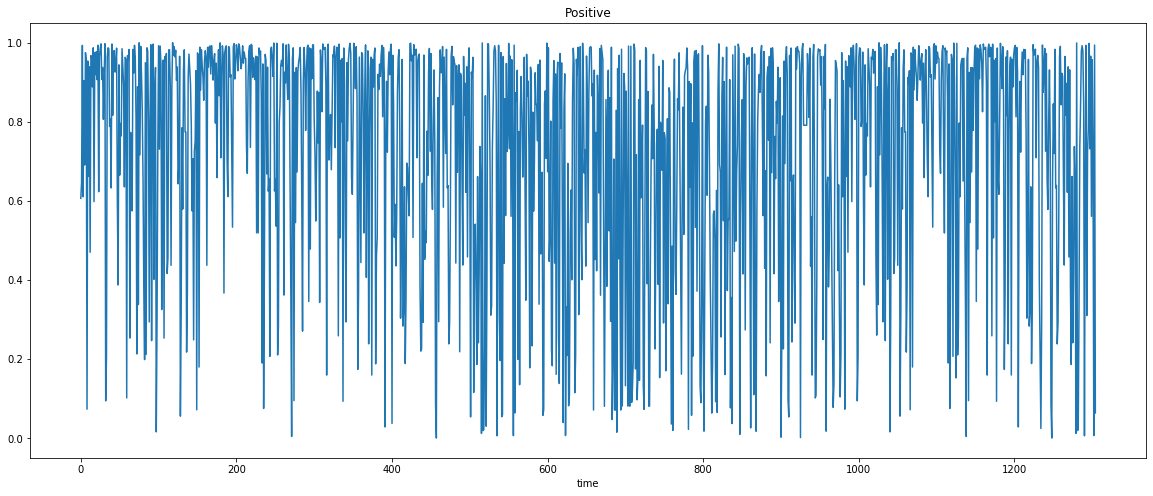

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(bj_senti.positive)
plt.title('Positive')
# plt.ylabel('')
plt.xlabel('time')
plt.grid(False)
plt.show()

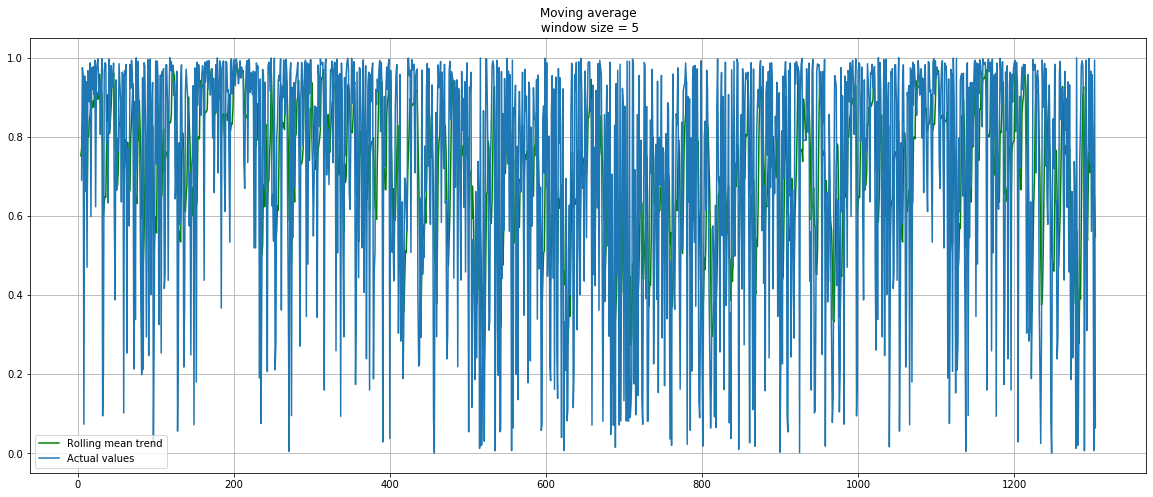

In [11]:
def plot_moving_average(series,window,plot_intervals=False, scale =1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(20,8))
    plt.title('Moving average\n window size = {}'.format(window))
    #smaller window, more details; more bigger window, you can see the plot
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    #plt.plot(lwd = 1)

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(bj_senti.positive, 5)

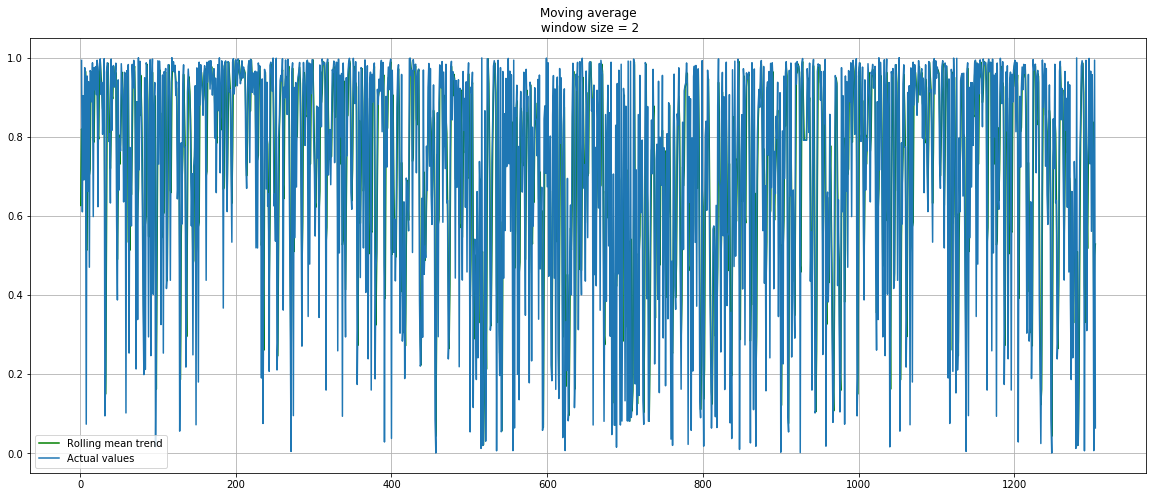

In [12]:
plot_moving_average(bj_senti.positive, 2)

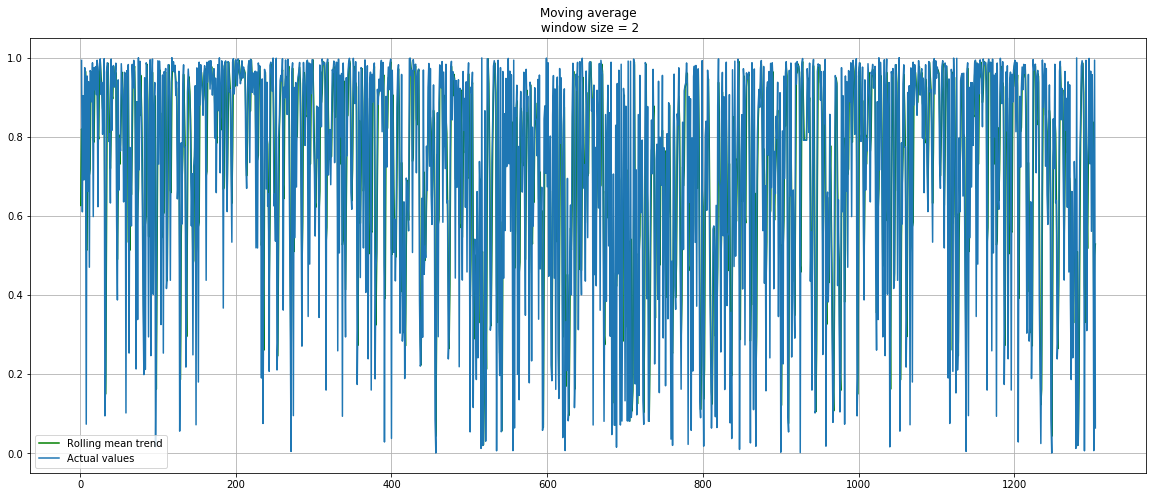

In [13]:
plot_moving_average(bj_senti.positive, 2, plot_intervals=False)

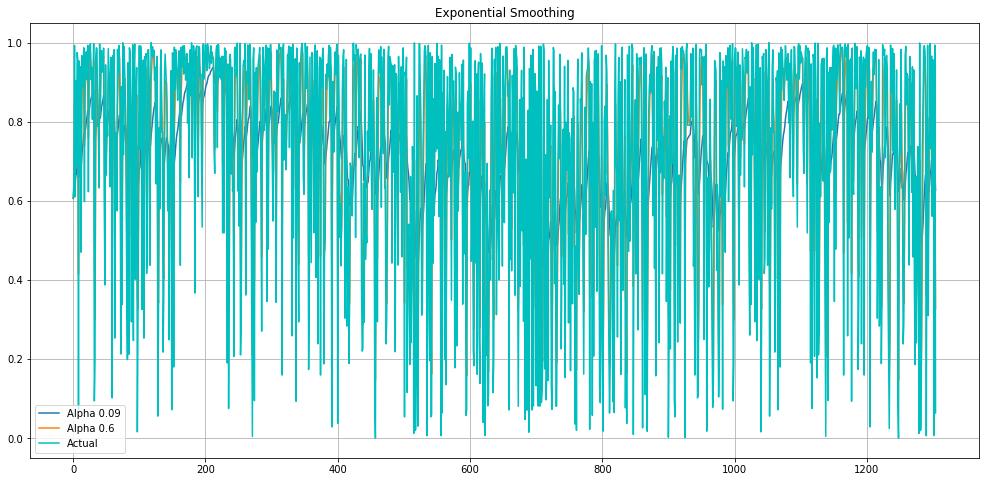

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(bj_senti.positive, [0.09, 0.6])

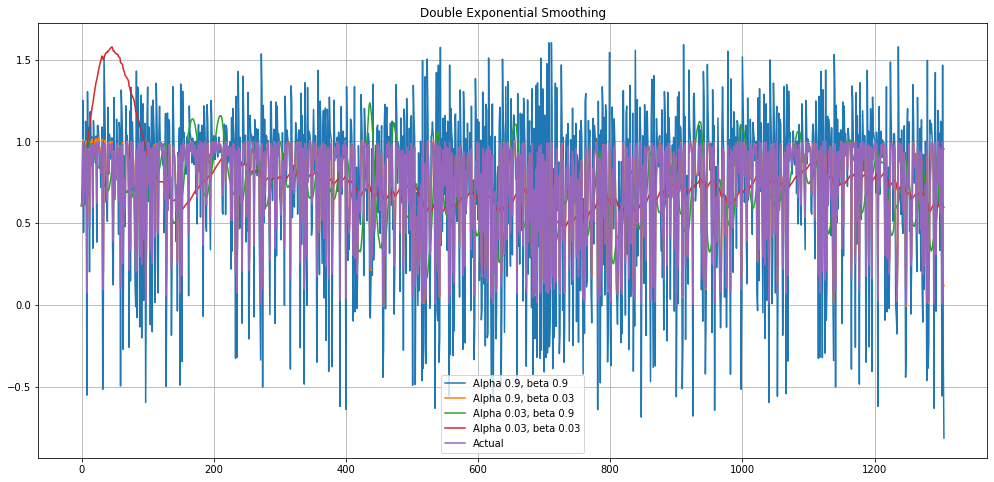

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(bj_senti.positive, alphas=[0.9, 0.03], betas=[0.9, 0.03])

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [17]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Positive Value')
    plt.plot(predicted, color='blue',label='Predicted Positive Value')
    plt.title('Positive Value Prediction')
    plt.xlabel('Time')
    plt.ylabel('Positive Value')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [36]:
# First, we get the data
dataset = pd.read_csv('data/Key-Word Beijing Weather_senti.csv', index_col='time', parse_dates=['time'])
dataset = dataset.sort_values(by="time" , ascending=True)
dataset

,positive,negative
time,,
2019-04-27,0.213496,0.786504
2019-04-27,0.104397,0.895603
2019-04-27,0.334572,0.665428
2019-04-28,0.035815,0.964185
2019-04-28,0.533036,0.466964
...,...,...
2019-05-01,0.732614,0.267386
2019-05-01,0.574652,0.425348
2019-05-01,0.983031,0.016969


In [37]:
dataset["newindex"] = range(len(dataset))
dataset

,positive,negative,newindex
time,,,
2019-04-27,0.213496,0.786504,0
2019-04-27,0.104397,0.895603,1
2019-04-27,0.334572,0.665428,2
2019-04-28,0.035815,0.964185,3
2019-04-28,0.533036,0.466964,4
...,...,...,...
2019-05-01,0.732614,0.267386,1300
2019-05-01,0.574652,0.425348,1301
2019-05-01,0.983031,0.016969,1302


In [38]:
dataset = dataset.set_index('newindex')
dataset

,positive,negative
newindex,,
0,0.213496,0.786504
1,0.104397,0.895603
2,0.334572,0.665428
3,0.035815,0.964185
4,0.533036,0.466964
...,...,...
1300,0.732614,0.267386
1301,0.574652,0.425348
1302,0.983031,0.016969


In [63]:
# Checking for missing values
training_set = dataset[:1000].iloc[:,:-1].values
test_set = dataset[1000:].iloc[:,:-1].values
training_set.shape

(1000, 1)

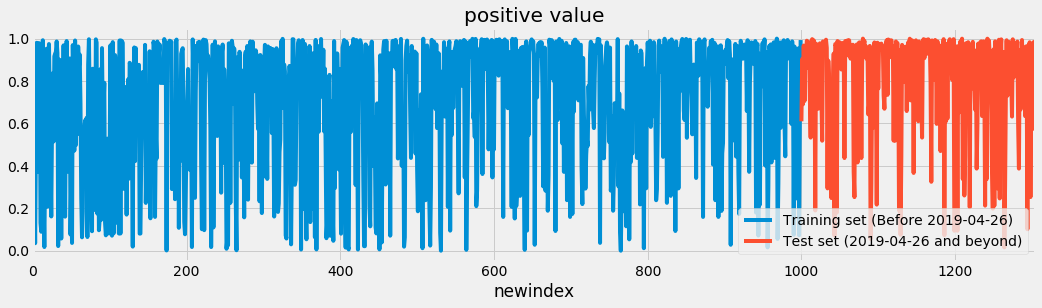

In [64]:
dataset["positive"][:1000].plot(figsize=(16,4),legend=True)
dataset["positive"][1000:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019-04-26)','Test set (2019-04-26 and beyond)'])
plt.title('positive value')
plt.show()

In [65]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(50,1000):
    X_train.append(training_set[i-50:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [66]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [67]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
950/950 [==============================] - 3s 4ms/step - loss: 0.1558
Epoch 2/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1099
Epoch 3/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1077
Epoch 4/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1107
Epoch 5/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1038
Epoch 6/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1037
Epoch 7/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1042
Epoch 8/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1042
Epoch 9/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1024
Epoch 10/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1024
Epoch 11/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1011
Epoch 12/50
950/950 [==============================] - 2s 2ms/step - loss: 0.1004
Epoch 13/50
950/950 [====

In [69]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
training_set

array([[0.21306805],
       [0.10390922],
       [0.33421056],
       [0.03529009],
       [0.53278304],
       [0.98028982],
       [0.37137014],
       [0.96767008],
       [0.97869612],
       [0.97190684],
       [0.13049382],
       [0.08932101],
       [0.35139503],
       [0.99242792],
       [0.25472952],
       [0.0173614 ],
       [0.40714982],
       [0.65361174],
       [0.95255436],
       [0.20733811],
       [0.79709106],
       [0.97438324],
       [0.70511232],
       [0.40030564],
       [0.16143206],
       [0.61007941],
       [0.83688498],
       [0.51481332],
       [0.91638423],
       [0.92872074],
       [0.93689706],
       [0.9866739 ],
       [0.93273519],
       [0.02190632],
       [0.90172274],
       [0.63413658],
       [0.89626579],
       [0.05733341],
       [0.8018937 ],
       [0.83941438],
       [0.968316  ],
       [0.83019062],
       [0.16050146],
       [0.69663121],
       [0.98865204],
       [0.37295266],
       [0.54923144],
       [0.557

In [70]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["positive"][:1000],dataset["positive"][1000:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 50:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs

array([[0.98193457],
       [0.92957916],
       [0.99656763],
       [0.40180576],
       [0.87149735],
       [0.93716572],
       [0.01611884],
       [0.30745654],
       [0.96460667],
       [0.95346256],
       [0.97256791],
       [0.41642815],
       [0.77437836],
       [0.4557431 ],
       [0.98237091],
       [0.8906012 ],
       [0.43720263],
       [0.88095764],
       [0.99999706],
       [0.05593364],
       [0.31641621],
       [0.78480993],
       [0.98224364],
       [0.57943015],
       [0.93402269],
       [0.98149948],
       [0.8659717 ],
       [0.99231894],
       [0.61084028],
       [0.44550855],
       [0.97039727],
       [0.95580898],
       [0.99350245],
       [0.9065834 ],
       [0.97750909],
       [0.9192903 ],
       [0.9747938 ],
       [0.59820127],
       [0.98706779],
       [0.88827273],
       [0.07530476],
       [0.96236406],
       [0.47021713],
       [0.93903672],
       [0.24679128],
       [0.66247219],
       [0.9537743 ],
       [0.073

In [72]:
test_set.shape

(305, 1)

In [73]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(50,355):
    X_test.append(inputs[i-50:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_positive_value = regressor.predict(X_test)
predicted_positive_value = sc.inverse_transform(predicted_positive_value)

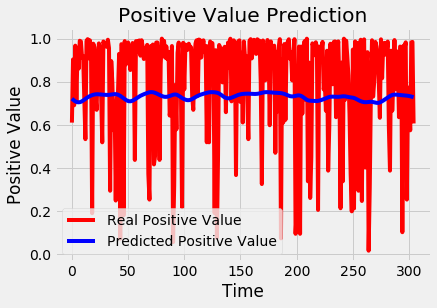

In [74]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_positive_value)

In [75]:
# Evaluating our model
return_rmse(test_set,predicted_positive_value)

The root mean squared error is 0.25840071340615506.
